<a href="https://colab.research.google.com/github/Bulahov/mifi/blob/main/rps_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Установка

In [ ]:
!pip install -q -U kaggle_environments

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.1 MB/s eta 0:00:00


### Import

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import Counter
from typing import Dict, Optional, List

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

### Агенты

In [ ]:
#агенты
def rock_agent(observation, configuration):
    """Агент всегда играет камень (0)"""
    return 0

def paper_agent(observation, configuration):
    """Агент всегда играет бумагу (1)"""
    return 1

def scissors_agent(observation, configuration):
    """Агент всегда играет ножницы (2)"""
    return 2

def random_agent(observation, configuration):
    """Агент играет случайный ход"""
    return random.randrange(configuration.signs)

def copy_opponent(observation, configuration):
    """Агент копирует последний ход противника"""
    if observation.step > 0:
        return observation.lastOpponentAction
    return random.randrange(configuration.signs)

def counter_last_move(observation, configuration):
    """Агент играет ход, побеждающий последний ход противника"""
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % configuration.signs
    return random.randrange(configuration.signs)

def pattern_based_agent(observation, configuration):
    """Агент играет по паттерну камень-бумага-ножницы"""
    return observation.step % configuration.signs

def frequency_counter(observation, configuration):
    """Агент анализирует частоту ходов противника и играет контр-стратегию"""
    if observation.step == 0:
        return random.randrange(configuration.signs)

    history = observation.step
    opponent_moves = [
        observation.lastOpponentAction
    ]

    # Находим самый частый ход противника
    most_common = max(set(opponent_moves), key=opponent_moves.count)
    # Играем ход, побеждающий самый частый ход противника
    return (most_common + 1) % configuration.signs

def rolling_window_agent(observation, configuration):
    """Агент анализирует последние 3 хода противника"""
    if observation.step < 3:
        return random.randrange(configuration.signs)

    # В реальной игре здесь был бы анализ паттернов
    return random.randrange(configuration.signs)

def adaptive_agent(observation, configuration):
    """Агент адаптируется к стратегии противника"""
    if observation.step == 0:
        return random.randrange(configuration.signs)

    # Если противник повторяет ходы, контрируем его последний ход
    if observation.step > 1 and observation.lastOpponentAction == observation.lastOpponentAction:
        return (observation.lastOpponentAction + 1) % configuration.signs

    return random.randrange(configuration.signs)

def momentum_agent(observation, configuration):
    """Агент учитывает победную серию"""
    if observation.step == 0:
        return random.randrange(configuration.signs)

    # Если последний ход был успешным, повторяем его
    last_move = observation.lastOpponentAction
    if last_move == (observation.lastOpponentAction - 1) % configuration.signs:
        return last_move

    return random.randrange(configuration.signs)

def anti_pattern_agent(observation, configuration):
    """Агент играет от противного - разрушает очевидные паттерны"""
    if observation.step == 0:
        return random.randrange(configuration.signs)

    # Играем ход, который победит предполагаемый ответ на наш последний ход
    expected_counter = (observation.lastOpponentAction + 1) % configuration.signs
    return (expected_counter + 1) % configuration.signs

def risk_averse_agent(observation, configuration):
    """Агент минимизирует риск поражения"""
    if observation.step == 0:
        return random.randrange(configuration.signs)

    # Играем ход, который как минимум приведет к ничьей с последним ходом противника
    return observation.lastOpponentAction

def statistical_agent(observation, configuration):
    """Агент использует простую статистику для принятия решений"""
    if observation.step < 5:
        return random.randrange(configuration.signs)

    # В реальной игре здесь был бы статистический анализ
    return random.randrange(configuration.signs)

### Турнир

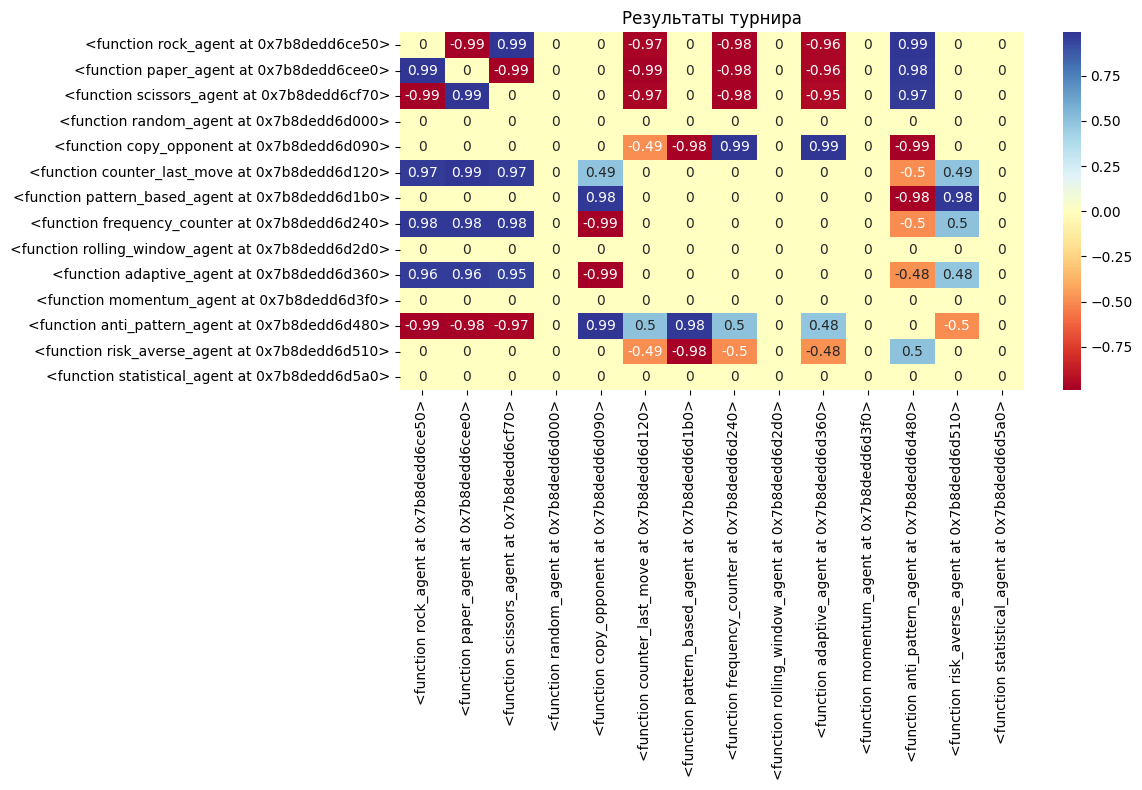


Средний счет каждого агента:
<function risk_averse_agent at 0x7b8dedd6d510>       0.139286
<function paper_agent at 0x7b8dedd6cee0>             0.139286
<function scissors_agent at 0x7b8dedd6cf70>          0.137857
<function rock_agent at 0x7b8dedd6ce50>              0.137143
<function copy_opponent at 0x7b8dedd6d090>           0.034286
<function random_agent at 0x7b8dedd6d000>            0.000000
<function rolling_window_agent at 0x7b8dedd6d2d0>    0.000000
<function momentum_agent at 0x7b8dedd6d3f0>          0.000000
<function statistical_agent at 0x7b8dedd6d5a0>       0.000000
<function anti_pattern_agent at 0x7b8dedd6d480>     -0.000714
<function pattern_based_agent at 0x7b8dedd6d1b0>    -0.070000
<function adaptive_agent at 0x7b8dedd6d360>         -0.134286
<function frequency_counter at 0x7b8dedd6d240>      -0.139286
<function counter_last_move at 0x7b8dedd6d120>      -0.243571
dtype: float64


In [ ]:


# Список всех агентов
agents = [
    rock_agent, paper_agent, scissors_agent, random_agent,
    copy_opponent, counter_last_move, pattern_based_agent,
    frequency_counter, rolling_window_agent, adaptive_agent,
    momentum_agent, anti_pattern_agent, risk_averse_agent,
    statistical_agent
]

def run_tournament(agents, episodes=100):
    """
    Проводит турнир между всеми агентами

    Args:
        agents (list): Список агентов
        episodes (int): Количество игр между каждой парой агентов

    Returns:
        pandas.DataFrame: Матрица результатов
    """
    n_agents = len(agents)
    results = np.zeros((n_agents, n_agents))

    for i in range(n_agents):
        for j in range(i + 1, n_agents):
            # Проводим игры между агентами
            outcome = evaluate("rps", [agents[i], agents[j]], configuration={"episodeSteps": episodes})

            # Записываем результаты
            results[i][j] = sum([o[0] for o in outcome]) / episodes
            results[j][i] = sum([o[1] for o in outcome]) / episodes

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results, columns=agents, index=agents)
    return results_df

def visualize_results(results_df):
    """
    Визуализирует результаты турнира

    Args:
        results_df (pandas.DataFrame): Матрица результатов
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(results_df, annot=True, cmap='RdYlBu', center=0)
    plt.title('Результаты турнира')
    plt.tight_layout()
    plt.show()

# Запускаем турнир
results = run_tournament(agents)
visualize_results(results)

# Выводим общую статистику
print("\nСредний счет каждого агента:")
print(results.mean().sort_values(ascending=False))